In [2]:
# Import 
import os
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from itertools import permutations
import time
import pandas as pd
from joblib import dump, load
from pathlib import Path

## sourceXray
from src.sourceXray_BJ import sourceXray, compute_C, solve_H_right_inverse
from src.utils import *
from src.simulate_nmf import simulate_dataset

## N-FINDR
from src.NFINDR import nfindr_BJ

## W 
import pysptools.abundance_maps as amp
nnls = amp.NNLS() # nonnegative constrained least squares and then row-normalize

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
# setting
K = 3
J = 8
n_reps = 50

# path 
outdir = Path("results/sims")
outdir.mkdir(parents=True, exist_ok=True)

In [3]:
# data dimensions to try
n_list = [100, 300]

# container to hold *all* results in memory
# results[n] -> dict of arrays (each of length n_reps)
results = {}

for n in n_list:
    print(f"\n=== Running experiments for n = {n} ===\n")

    # allocate per-n arrays
    per_n = {
        # time
        "time_sourceXray": np.zeros(n_reps),
        "time_nfindr": np.zeros(n_reps),
        # H metrics
        "H_rmssad_sourceXray": np.zeros(n_reps),
        "H_fro_sourceXray": np.zeros(n_reps),
        "H_nrmse_sourceXray": np.zeros(n_reps),
        "H_rmssad_nfindr": np.zeros(n_reps),
        "H_fro_nfindr": np.zeros(n_reps),
        "H_nrmse_nfindr": np.zeros(n_reps),
        # C metrics
        "C_fro_sourceXray": np.zeros(n_reps),
        "C_nrmse_sourceXray": np.zeros(n_reps),
        "C_fro_nfindr": np.zeros(n_reps),
        "C_nrmse_nfindr": np.zeros(n_reps),
    }
    
    est_per_n = {
        "C_hat_sourceXray": np.empty((n_reps, J, K), dtype=float),
        "C_hat_nfindr": np.empty((n_reps, J, K), dtype=float),
        "H_star_hat_sourceXray": np.empty((n_reps, K, J), dtype=float),
        "H_star_hat_nfindr": np.empty((n_reps, K, J), dtype=float),
        "C": np.empty((n_reps, J, K), dtype=float),
        "H_star": np.empty((n_reps, K, J), dtype=float),
    }

    for rep in range(n_reps):
        print(f"n={n}, rep {rep+1}/{n_reps}", flush=True)
        
        # simulate data 
        seed = n+rep
        Y, Y_star, r, H, H_star, W, mu, W_tilde, mu_tilde, W_star, C, C_alt = simulate_dataset(n=n, K=K, J=J, seed=seed, process="ar1")
        est_per_n["C"][rep] = C
        est_per_n["H_star"][rep] = H_star
        
        # ---------- sourceXray ----------
        t0 = time.time()
        H_star_hat, W_tilde_hat, mu_tilde_hat, C_hat, logvol_hat = sourceXray(Y, K, seed=seed, prune=False, verbose=False)[0]
        t1 = time.time()
        per_n["time_sourceXray"][rep] = t1 - t0

        # permute to match truth
        H_star_hat_perm, mu_tilde_hat_perm, C_hat_perm, _ = (
            permute_estimates_to_match_truth(H_star, H_star_hat, mu_tilde_hat, C_hat)
        )
        est_per_n["C_hat_sourceXray"][rep] = C_hat_perm
        est_per_n["H_star_hat_sourceXray"][rep] = H_star_hat_perm

        # metrics (H)
        per_n["H_rmssad_sourceXray"][rep] = rms_sad(H_star, H_star_hat_perm)['rms_sad']
        per_n["H_fro_sourceXray"][rep] = frobenius_dist(H_star, H_star_hat_perm, relative=True)
        per_n["H_nrmse_sourceXray"][rep] = nrmse(H_star, H_star_hat_perm)['nrmse']
        # metrics (C)
        per_n["C_fro_sourceXray"][rep] = frobenius_dist(C, C_hat_perm, relative=True)
        per_n["C_nrmse_sourceXray"][rep] = nrmse(C, C_hat_perm)['nrmse']

        # ---------- N-FINDR ----------
        t0 = time.time()
        H_star_hat_nfindr, _ = nfindr_BJ(Y_star, K, max_iter=5, seed=seed, normalize=False, init='atgp')
        W_star_hat_nfindr, _, _ = solve_H_right_inverse(Y_star, H_star_hat_nfindr)
        W_tilde_hat_nfindr = W_star_hat_nfindr * r
        mu_tilde_hat_nfindr = W_tilde_hat_nfindr.mean(axis=0)
        C_hat_nfindr = compute_C(mu_tilde_hat_nfindr, H_star_hat_nfindr)
        t1 = time.time()
        per_n["time_nfindr"][rep] = t1 - t0

        # permute to match truth
        H_star_hat_perm_nfindr, mu_tilde_hat_perm_nfindr, C_hat_perm_nfindr, _ = (
            permute_estimates_to_match_truth(H_star, H_star_hat_nfindr, mu_tilde_hat_nfindr, C_hat_nfindr)
        )
        est_per_n["C_hat_nfindr"][rep] = C_hat_perm_nfindr
        est_per_n["H_star_hat_nfindr"][rep] = H_star_hat_perm_nfindr
        
        # metrics (H)
        per_n["H_rmssad_nfindr"][rep] = rms_sad(H_star, H_star_hat_perm_nfindr)['rms_sad']
        per_n["H_fro_nfindr"][rep] = frobenius_dist(H_star, H_star_hat_perm_nfindr, relative=True)
        per_n["H_nrmse_nfindr"][rep] = nrmse(H_star, H_star_hat_perm_nfindr)['nrmse']
        # metrics (C)
        per_n["C_fro_nfindr"][rep] = frobenius_dist(C, C_hat_perm_nfindr, relative=True)
        per_n["C_nrmse_nfindr"][rep] = nrmse(C, C_hat_perm_nfindr)['nrmse']

    # stash arrays for this n
    results[n] = {
        "metrics": per_n,
        "estimates": est_per_n
    }
    
    # save
    dump(results[n], outdir/f"sourceXray_convergence_sims_ar1W_RinvH_J8K3_n{n}.joblib")


=== Running experiments for n = 100 ===

n=100, rep 1/50
n=100, rep 2/50
n=100, rep 3/50
n=100, rep 4/50



KeyboardInterrupt



In [66]:
# data dimensions to try
n_list = [1500, 10000, 100000, 500000]

for n in n_list:
    print(f"\n=== Running experiments for n = {n} ===\n")

    # allocate per-n arrays
    per_n = {
        # time
        "time_nfindr": np.zeros(n_reps),
        # H metrics
        "H_rmssad_nfindr": np.zeros(n_reps),
        "H_fro_nfindr": np.zeros(n_reps),
        "H_nrmse_nfindr": np.zeros(n_reps),
        # C metrics
        "C_fro_nfindr": np.zeros(n_reps),
        "C_nrmse_nfindr": np.zeros(n_reps),
    }
    
    est_per_n = {
        "C_hat_nfindr": np.empty((n_reps, J, K), dtype=float),
        "H_star_hat_nfindr": np.empty((n_reps, K, J), dtype=float),
        "C": np.empty((n_reps, J, K), dtype=float),
        "H_star": np.empty((n_reps, K, J), dtype=float),
    }

    for rep in range(n_reps):
        print(f"n={n}, rep {rep+1}/{n_reps}", flush=True)
        
        # simulate data 
        seed = n+rep
        Y, Y_star, r, H, H_star, W, mu, W_tilde, mu_tilde, W_star, C, C_alt = simulate_dataset(n=n, K=K, J=J, seed=seed, process="ar1")
        est_per_n["C"][rep] = C
        est_per_n["H_star"][rep] = H_star

        # ---------- N-FINDR ----------
        t0 = time.time()
        H_star_hat_nfindr, _ = nfindr_BJ(Y_star, K, max_iter=5, seed=seed, normalize=False, init='atgp')
        W_star_hat_nfindr, _, _ = solve_H_right_inverse(Y_star, H_star_hat_nfindr)
        W_tilde_hat_nfindr = W_star_hat_nfindr * r
        mu_tilde_hat_nfindr = W_tilde_hat_nfindr.mean(axis=0)
        C_hat_nfindr = compute_C(mu_tilde_hat_nfindr, H_star_hat_nfindr)
        t1 = time.time()
        per_n["time_nfindr"][rep] = t1 - t0

        # permute to match truth
        H_star_hat_perm_nfindr, mu_tilde_hat_perm_nfindr, C_hat_perm_nfindr, _ = (
            permute_estimates_to_match_truth(H_star, H_star_hat_nfindr, mu_tilde_hat_nfindr, C_hat_nfindr)
        )
        est_per_n["C_hat_nfindr"][rep] = C_hat_perm_nfindr
        est_per_n["H_star_hat_nfindr"][rep] = H_star_hat_perm_nfindr
        
        # metrics (H)
        per_n["H_rmssad_nfindr"][rep] = rms_sad(H_star, H_star_hat_perm_nfindr)['rms_sad']
        per_n["H_fro_nfindr"][rep] = frobenius_dist(H_star, H_star_hat_perm_nfindr, relative=True)
        per_n["H_nrmse_nfindr"][rep] = nrmse(H_star, H_star_hat_perm_nfindr)['nrmse']
        # metrics (C)
        per_n["C_fro_nfindr"][rep] = frobenius_dist(C, C_hat_perm_nfindr, relative=True)
        per_n["C_nrmse_nfindr"][rep] = nrmse(C, C_hat_perm_nfindr)['nrmse']

    # stash arrays for this n
    results[n] = {
        "metrics": per_n,
        "estimates": est_per_n
    }
    
    # save
    dump(results[n], outdir/f"sourceXray_convergence_sims_ar1W_RinvH_J8K3_n{n}.joblib")


=== Running experiments for n = 1500 ===

n=1500, rep 1/50
n=1500, rep 2/50
n=1500, rep 3/50
n=1500, rep 4/50
n=1500, rep 5/50
n=1500, rep 6/50
n=1500, rep 7/50
n=1500, rep 8/50
n=1500, rep 9/50
n=1500, rep 10/50
n=1500, rep 11/50
n=1500, rep 12/50
n=1500, rep 13/50
n=1500, rep 14/50
n=1500, rep 15/50
n=1500, rep 16/50
n=1500, rep 17/50
n=1500, rep 18/50
n=1500, rep 19/50
n=1500, rep 20/50
n=1500, rep 21/50
n=1500, rep 22/50
n=1500, rep 23/50
n=1500, rep 24/50
n=1500, rep 25/50
n=1500, rep 26/50
n=1500, rep 27/50
n=1500, rep 28/50
n=1500, rep 29/50
n=1500, rep 30/50
n=1500, rep 31/50
n=1500, rep 32/50
n=1500, rep 33/50
n=1500, rep 34/50
n=1500, rep 35/50
n=1500, rep 36/50
n=1500, rep 37/50
n=1500, rep 38/50
n=1500, rep 39/50
n=1500, rep 40/50
n=1500, rep 41/50
n=1500, rep 42/50
n=1500, rep 43/50
n=1500, rep 44/50
n=1500, rep 45/50
n=1500, rep 46/50
n=1500, rep 47/50
n=1500, rep 48/50
n=1500, rep 49/50
n=1500, rep 50/50

=== Running experiments for n = 10000 ===

n=10000, rep 1/50
n=10

In [39]:
dump(results, outdir/"sourceXray_convergence_sims_ar1W_RinvH_J8K3.joblib")

['results/sims/sourceXray_convergence_sims_ar1W_RinvH_J8K3.joblib']

In [6]:
results = load("results/sims/sourceXray_convergence_sims_ar1W_RinvH_J8K3.joblib")

# Collect the union of metric keys across all n's (since some n's have fewer metrics)
all_metric_keys = sorted({
    k
    for bundle in results.values()
    for k in bundle["metrics"].keys()
})

# Long table: one row per (n, rep), columns for all metrics (NaN if missing)
records = []
for n, bundle in results.items():
    per_n = bundle["metrics"]
    for rep in range(n_reps):
        rec = {"n": n, "rep": rep}
        for mk in all_metric_keys:
            arr = per_n.get(mk, None)
            rec[mk] = (arr[rep] if arr is not None and rep < len(arr) else np.nan)
        records.append(rec)

df_long = pd.DataFrame.from_records(records).sort_values(["n", "rep"]).reset_index(drop=True)

# Per-n summary: mean and std across reps (numeric cols only)
metric_cols = [c for c in df_long.columns if c not in ("n", "rep")]

summary_mean = (
    df_long.groupby("n", as_index=False)[metric_cols]
    .mean(numeric_only=True)
    .rename(columns={c: f"{c}_mean" for c in metric_cols})
)
summary_std = (
    df_long.groupby("n", as_index=False)[metric_cols]
    .std(ddof=1, numeric_only=True)
    .rename(columns={c: f"{c}_std" for c in metric_cols})
)

# merge mean and std on n
df_summary = summary_mean.merge(summary_std, on="n", how="left")

In [7]:
# # Save to disk next to your other outputs
# (df_long).to_csv(outdir / "df_long.csv", index=False)
# (df_summary).to_csv(outdir / "df_summary.csv", index=False)

print("\nPer-n summary:")
print(df_summary[["n", "time_nfindr_mean", "time_nfindr_std", "time_sourceXray_mean", "time_sourceXray_std", 
                  "C_fro_nfindr_mean", "C_fro_nfindr_std", "C_fro_sourceXray_mean", "C_fro_sourceXray_std",
                  "C_nrmse_nfindr_mean", "C_nrmse_nfindr_std", "C_nrmse_sourceXray_mean", "C_nrmse_sourceXray_std"]])


Per-n summary:
        n  time_nfindr_mean  time_nfindr_std  time_sourceXray_mean  \
0     100          0.003976         0.000780              0.001781   
1     300          0.011521         0.001981              0.002245   
2    1500          0.054945         0.007804                   NaN   
3   10000          0.412508         0.062863                   NaN   
4  100000          3.841124         0.642244                   NaN   
5  500000         19.427463         3.525578                   NaN   

   time_sourceXray_std  C_fro_nfindr_mean  C_fro_nfindr_std  \
0             0.000809           0.320523          0.076353   
1             0.000931           0.254562          0.072915   
2                  NaN           0.181603          0.062269   
3                  NaN           0.140797          0.054270   
4                  NaN           0.118188          0.051325   
5                  NaN           0.088912          0.047786   

   C_fro_sourceXray_mean  C_fro_sourceXray_std  C_n

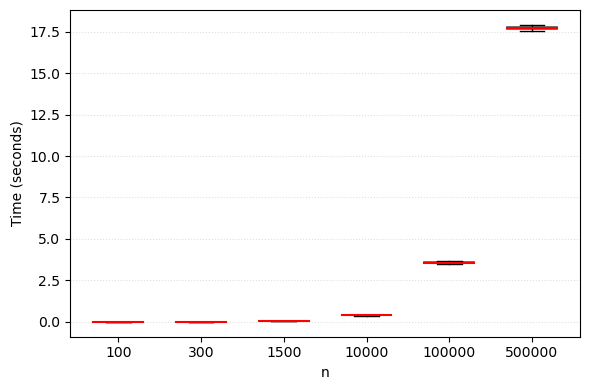

In [8]:
# Build a time-only long table from df_long
time_cols = [c for c in df_long.columns if c.startswith("time_")]
df_time = df_long.melt(
    id_vars=["n", "rep"],
    value_vars=time_cols,
    var_name="algorithm",
    value_name="value",
).dropna(subset=["value"])
df_time["algorithm"] = (
    df_time["algorithm"]
      .str.replace("^time_", "", regex=True)
      .replace({"nfindr": "Greedy search", 
                "sourceXray": "Exhaustive search"})   # <- rename for plotting
)
facet_boxplots(
    df=df_time,
    desired_algos=("Greedy search",),
    showfliers=False,
    figsize_per_panel=(6, 4),
    free_y=True,
    # savepath=outdir/"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_time.pdf", 
    metric_label="Time (seconds)",
    title=False
)

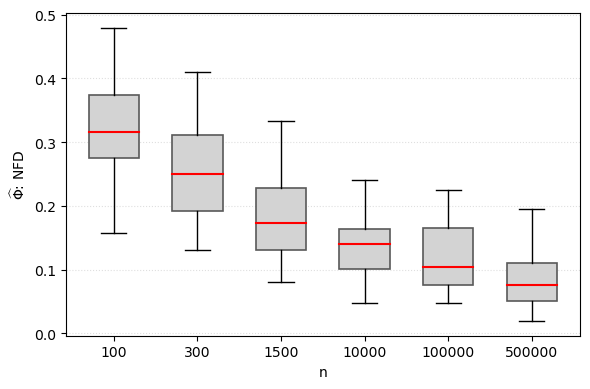

In [9]:
# Build a C_fro-only long table from df_long
C_fro_cols = [c for c in df_long.columns if c.startswith("C_fro_")]
df_C_fro = df_long.melt(
    id_vars=["n", "rep"],
    value_vars=C_fro_cols,
    var_name="algorithm",
    value_name="value",
).dropna(subset=["value"])
df_C_fro["algorithm"] = (
    df_C_fro["algorithm"]
      .str.replace("^C_fro_", "", regex=True)
      .replace({"nfindr": "Greedy search", 
                "sourceXray": "Exhaustive search"})
)
facet_boxplots(
    df=df_C_fro,
    desired_algos=("Greedy search",),
    showfliers=False,
    figsize_per_panel=(6, 4),
    free_y=False,
    # savepath=outdir/"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_PhiNFD.pdf", 
    metric_label="$\widehat{\Phi}$: NFD",
    title=False
)

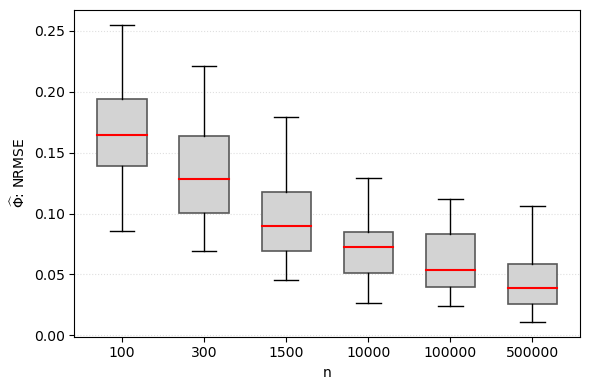

In [10]:
# Build a C_nrmse-only long table from df_long
C_nrmse_cols = [c for c in df_long.columns if c.startswith("C_nrmse_")]
df_C_nrmse = df_long.melt(
    id_vars=["n", "rep"],
    value_vars=C_nrmse_cols,
    var_name="algorithm",
    value_name="value",
).dropna(subset=["value"])
df_C_nrmse["algorithm"] = (
    df_C_nrmse["algorithm"]
      .str.replace("^C_nrmse_", "", regex=True)
      .replace({"nfindr": "Greedy search", 
                "sourceXray": "Exhaustive search"})
)
facet_boxplots(
    df=df_C_nrmse,
    desired_algos=("Greedy search",),
    showfliers=False,
    figsize_per_panel=(6, 4),
    free_y=False,
    # savepath=outdir/"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_PhiNRMSE.pdf", 
    metric_label="$\widehat{\Phi}$: NRMSE",
    title=False
)

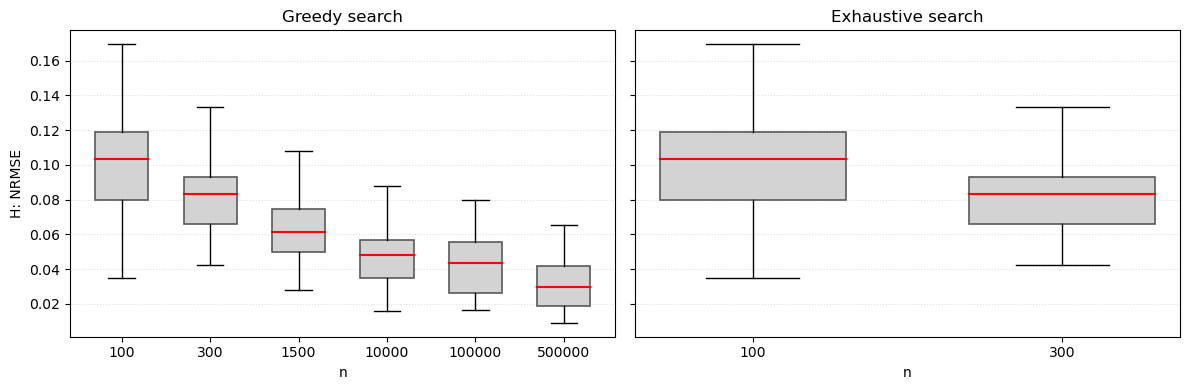

In [11]:
# Build a H_nrmse-only long table from df_long
H_nrmse_cols = [c for c in df_long.columns if c.startswith("H_nrmse_")]
df_H_nrmse = df_long.melt(
    id_vars=["n", "rep"],
    value_vars=H_nrmse_cols,
    var_name="algorithm",
    value_name="value",
).dropna(subset=["value"])
df_H_nrmse["algorithm"] = (
    df_H_nrmse["algorithm"]
      .str.replace("^H_nrmse_", "", regex=True)
      .replace({"nfindr": "Greedy search", 
                "sourceXray": "Exhaustive search"})
)
facet_boxplots(
    df = df_H_nrmse,
    showfliers=False,
    figsize_per_panel=(6, 4),
    free_y=False,
    savepath=None, 
    metric_label="H: NRMSE"
)

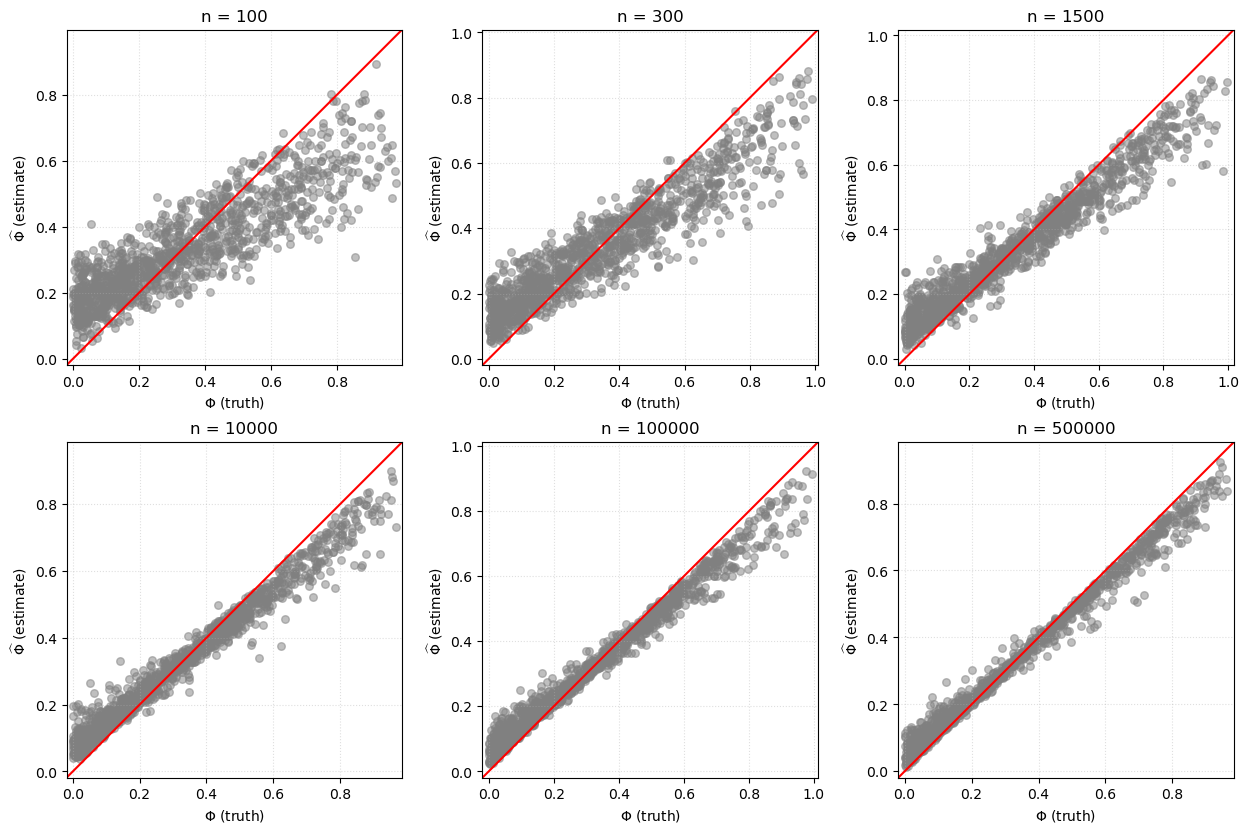

In [12]:
dct_C = {}
for n in [100, 300]:
    # stash arrays for this n
    dct_C[n] = {
        "true": results[n]["estimates"]["C"], 
        "hat_sourceXray": results[n]["estimates"]["C_hat_sourceXray"],
        "hat_nfindr": results[n]["estimates"]["C_hat_nfindr"],
    }
for n in [1500, 10000, 100000, 500000]:
    # stash arrays for this n
    dct_C[n] = {
        "true": results[n]["estimates"]["C"], 
        "hat_nfindr": results[n]["estimates"]["C_hat_nfindr"],
    }
scatter_faceted(
    dct_C,
    ncols=3,                 # panels per row
    s=30,                    # marker size
    alpha=0.5,               # point transparency
    xmax_pad=0.02,           # padding for axis limits
    # savepath=outdir/"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_PhiScatter.pdf", 
    xlabel="$\Phi$ (truth)",
    ylabel="$\widehat{\Phi}$ (estimate)", 
    alg_rename={"nfindr":"Greedy search","sourcexray":"Exhaustive search"},
    desired_algos=("Greedy search",),
    show_legend=False
)   

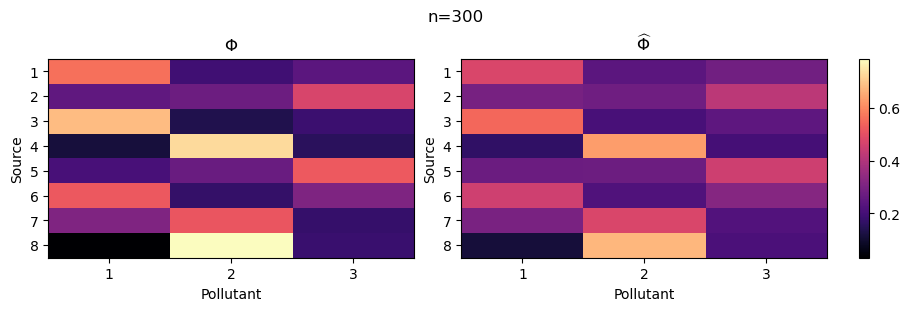

In [13]:
n = 300
C = results[n]["estimates"]["C"][0,:,:]
C_hat = results[n]["estimates"]["C_hat_nfindr"][0,:,:]
plot_H_comparison(
    C, C_hat,
    left_title=r"$\Phi$", 
    right_title=r"$\widehat{\Phi}$",
    xlabel="Pollutant",
    ylabel="Source",
    title=f"n={n}",                 # figure-level title (suptitle)
    cmap="magma",             # fill color (colormap)
    vmin=None, vmax=None,       # shared color scale; if None, computed from both
    cbar_label="",
    cbar_location="right",      # 'right', 'bottom', 'left', 'top'
    figsize=(9, 3),
    constrained_layout=True,
    show_ticks=True, 
    # savepath=outdir/f"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_PhiHeatmap_n{n}.pdf", 
)

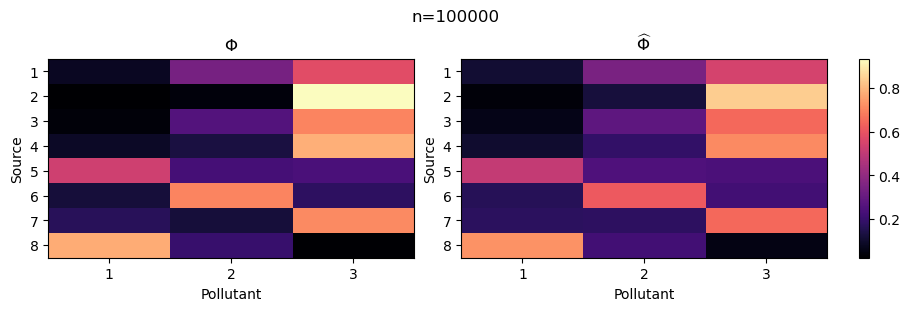

In [14]:
n = 100000
C = results[n]["estimates"]["C"][0,:,:]
C_hat = results[n]["estimates"]["C_hat_nfindr"][0,:,:]
plot_H_comparison(
    C, C_hat,
    left_title=r"$\Phi$", 
    right_title=r"$\widehat{\Phi}$",
    xlabel="Pollutant",
    ylabel="Source",
    title=f"n={n}",                 # figure-level title (suptitle)
    cmap="magma",             # fill color (colormap)
    vmin=None, vmax=None,       # shared color scale; if None, computed from both
    cbar_label="",
    cbar_location="right",      # 'right', 'bottom', 'left', 'top'
    figsize=(9, 3),
    constrained_layout=True,
    show_ticks=True, 
    # savepath=outdir/f"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_PhiHeatmap_n{n}.pdf", 
)

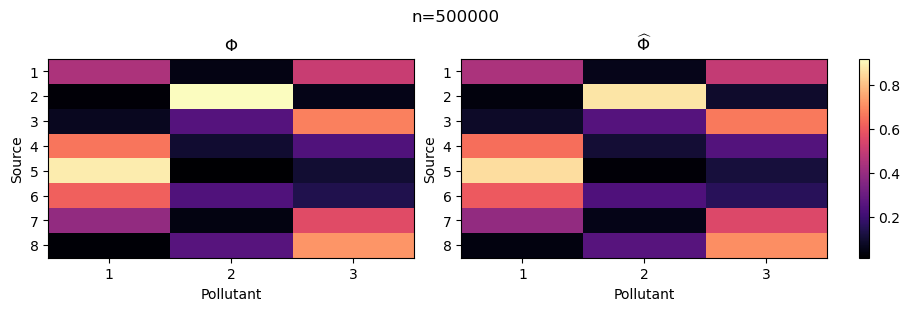

In [15]:
n = 500000
C = results[n]["estimates"]["C"][0,:,:]
C_hat = results[n]["estimates"]["C_hat_nfindr"][0,:,:]
plot_H_comparison(
    C, C_hat,
    left_title=r"$\Phi$", 
    right_title=r"$\widehat{\Phi}$",
    xlabel="Pollutant",
    ylabel="Source",
    title=f"n={n}",                 # figure-level title (suptitle)
    cmap="magma",             # fill color (colormap)
    vmin=None, vmax=None,       # shared color scale; if None, computed from both
    cbar_label="",
    cbar_location="right",      # 'right', 'bottom', 'left', 'top'
    figsize=(9, 3),
    constrained_layout=True,
    show_ticks=True, 
    # savepath=outdir/f"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_PhiHeatmap_n{n}.pdf", 
)

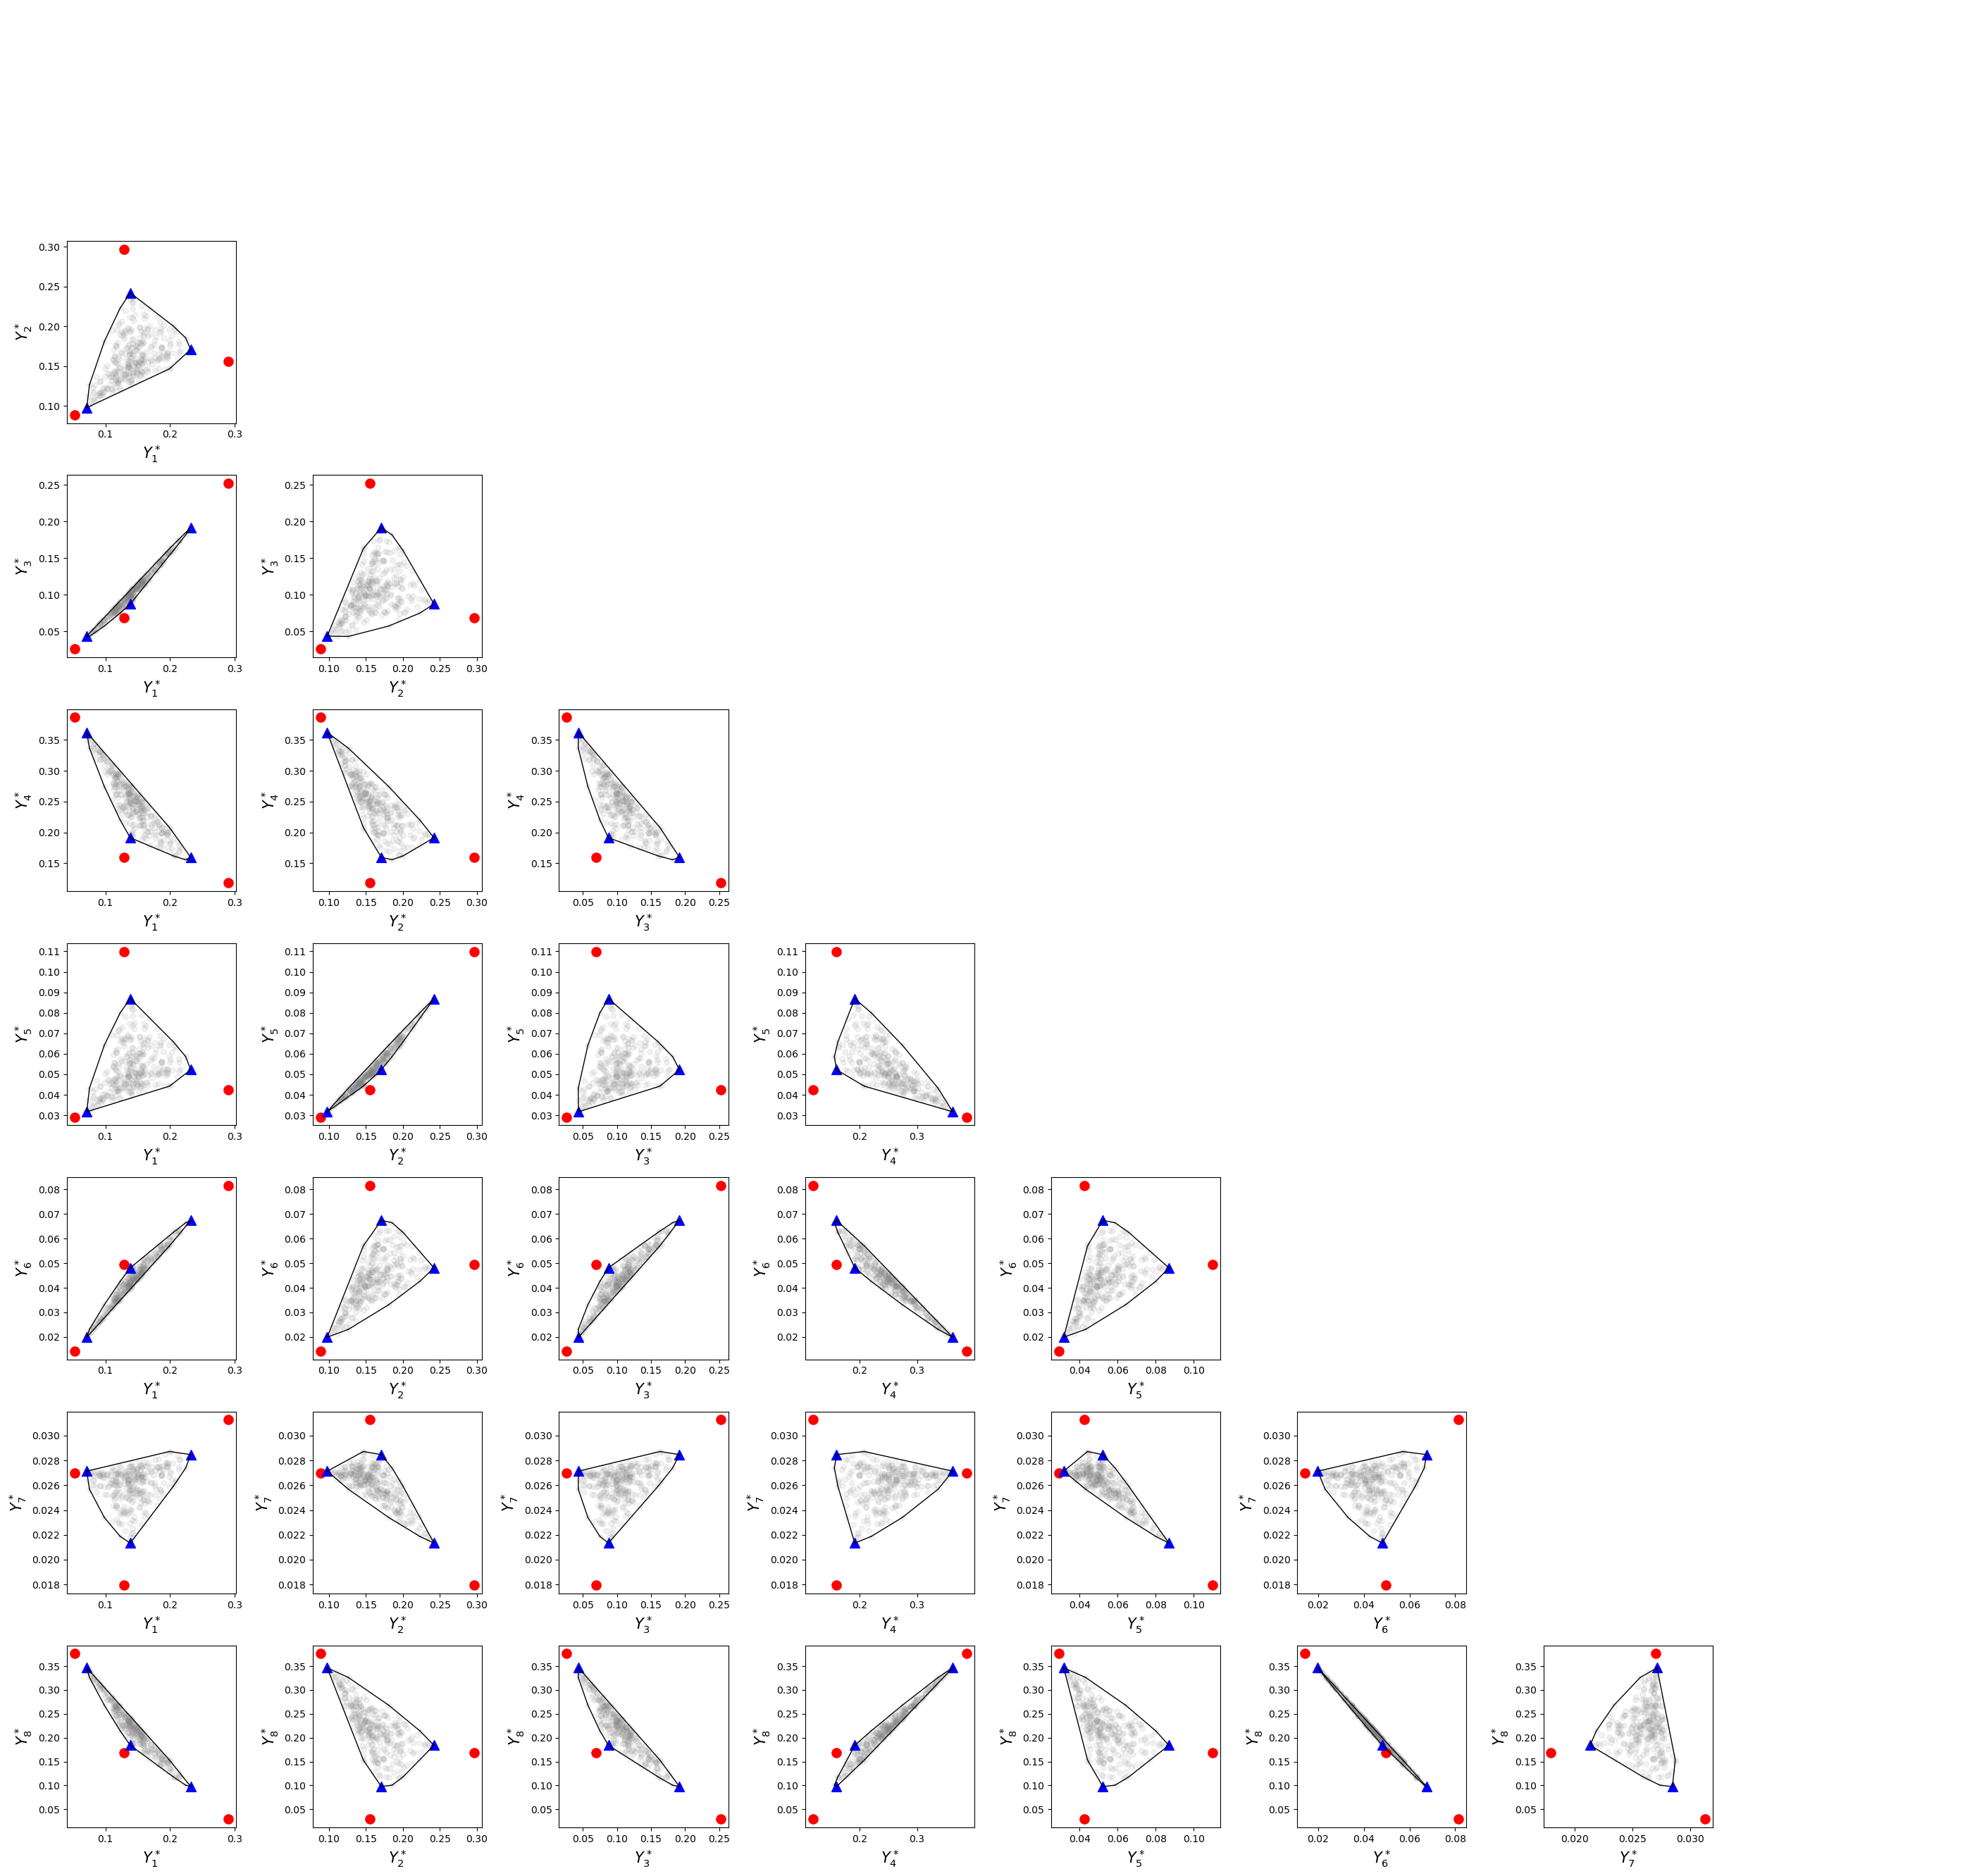

In [17]:
n = 300
seed = n
H_star_hat = results[n]["estimates"]["H_star_hat_nfindr"][0,:,:]
Y, Y_star, r, H, H_star, W, mu, W_tilde, mu_tilde, W_star, C, C_alt = simulate_dataset(n=n, K=K, J=J, seed=seed, process="ar1")
plot_full_scatter_matrix(Y_star, 
                         H=H_star, 
                         H_hat=H_star_hat, 
                         alpha=0.1, 
                         labels=[rf"$Y^*_{{{j+1}}}$" for j in range(J)],
                         draw_diagonal=False,
                         title=None, 
                         quantile=None, 
                         # savepath=outdir/f"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_HwScatter_n{n}.png"
)

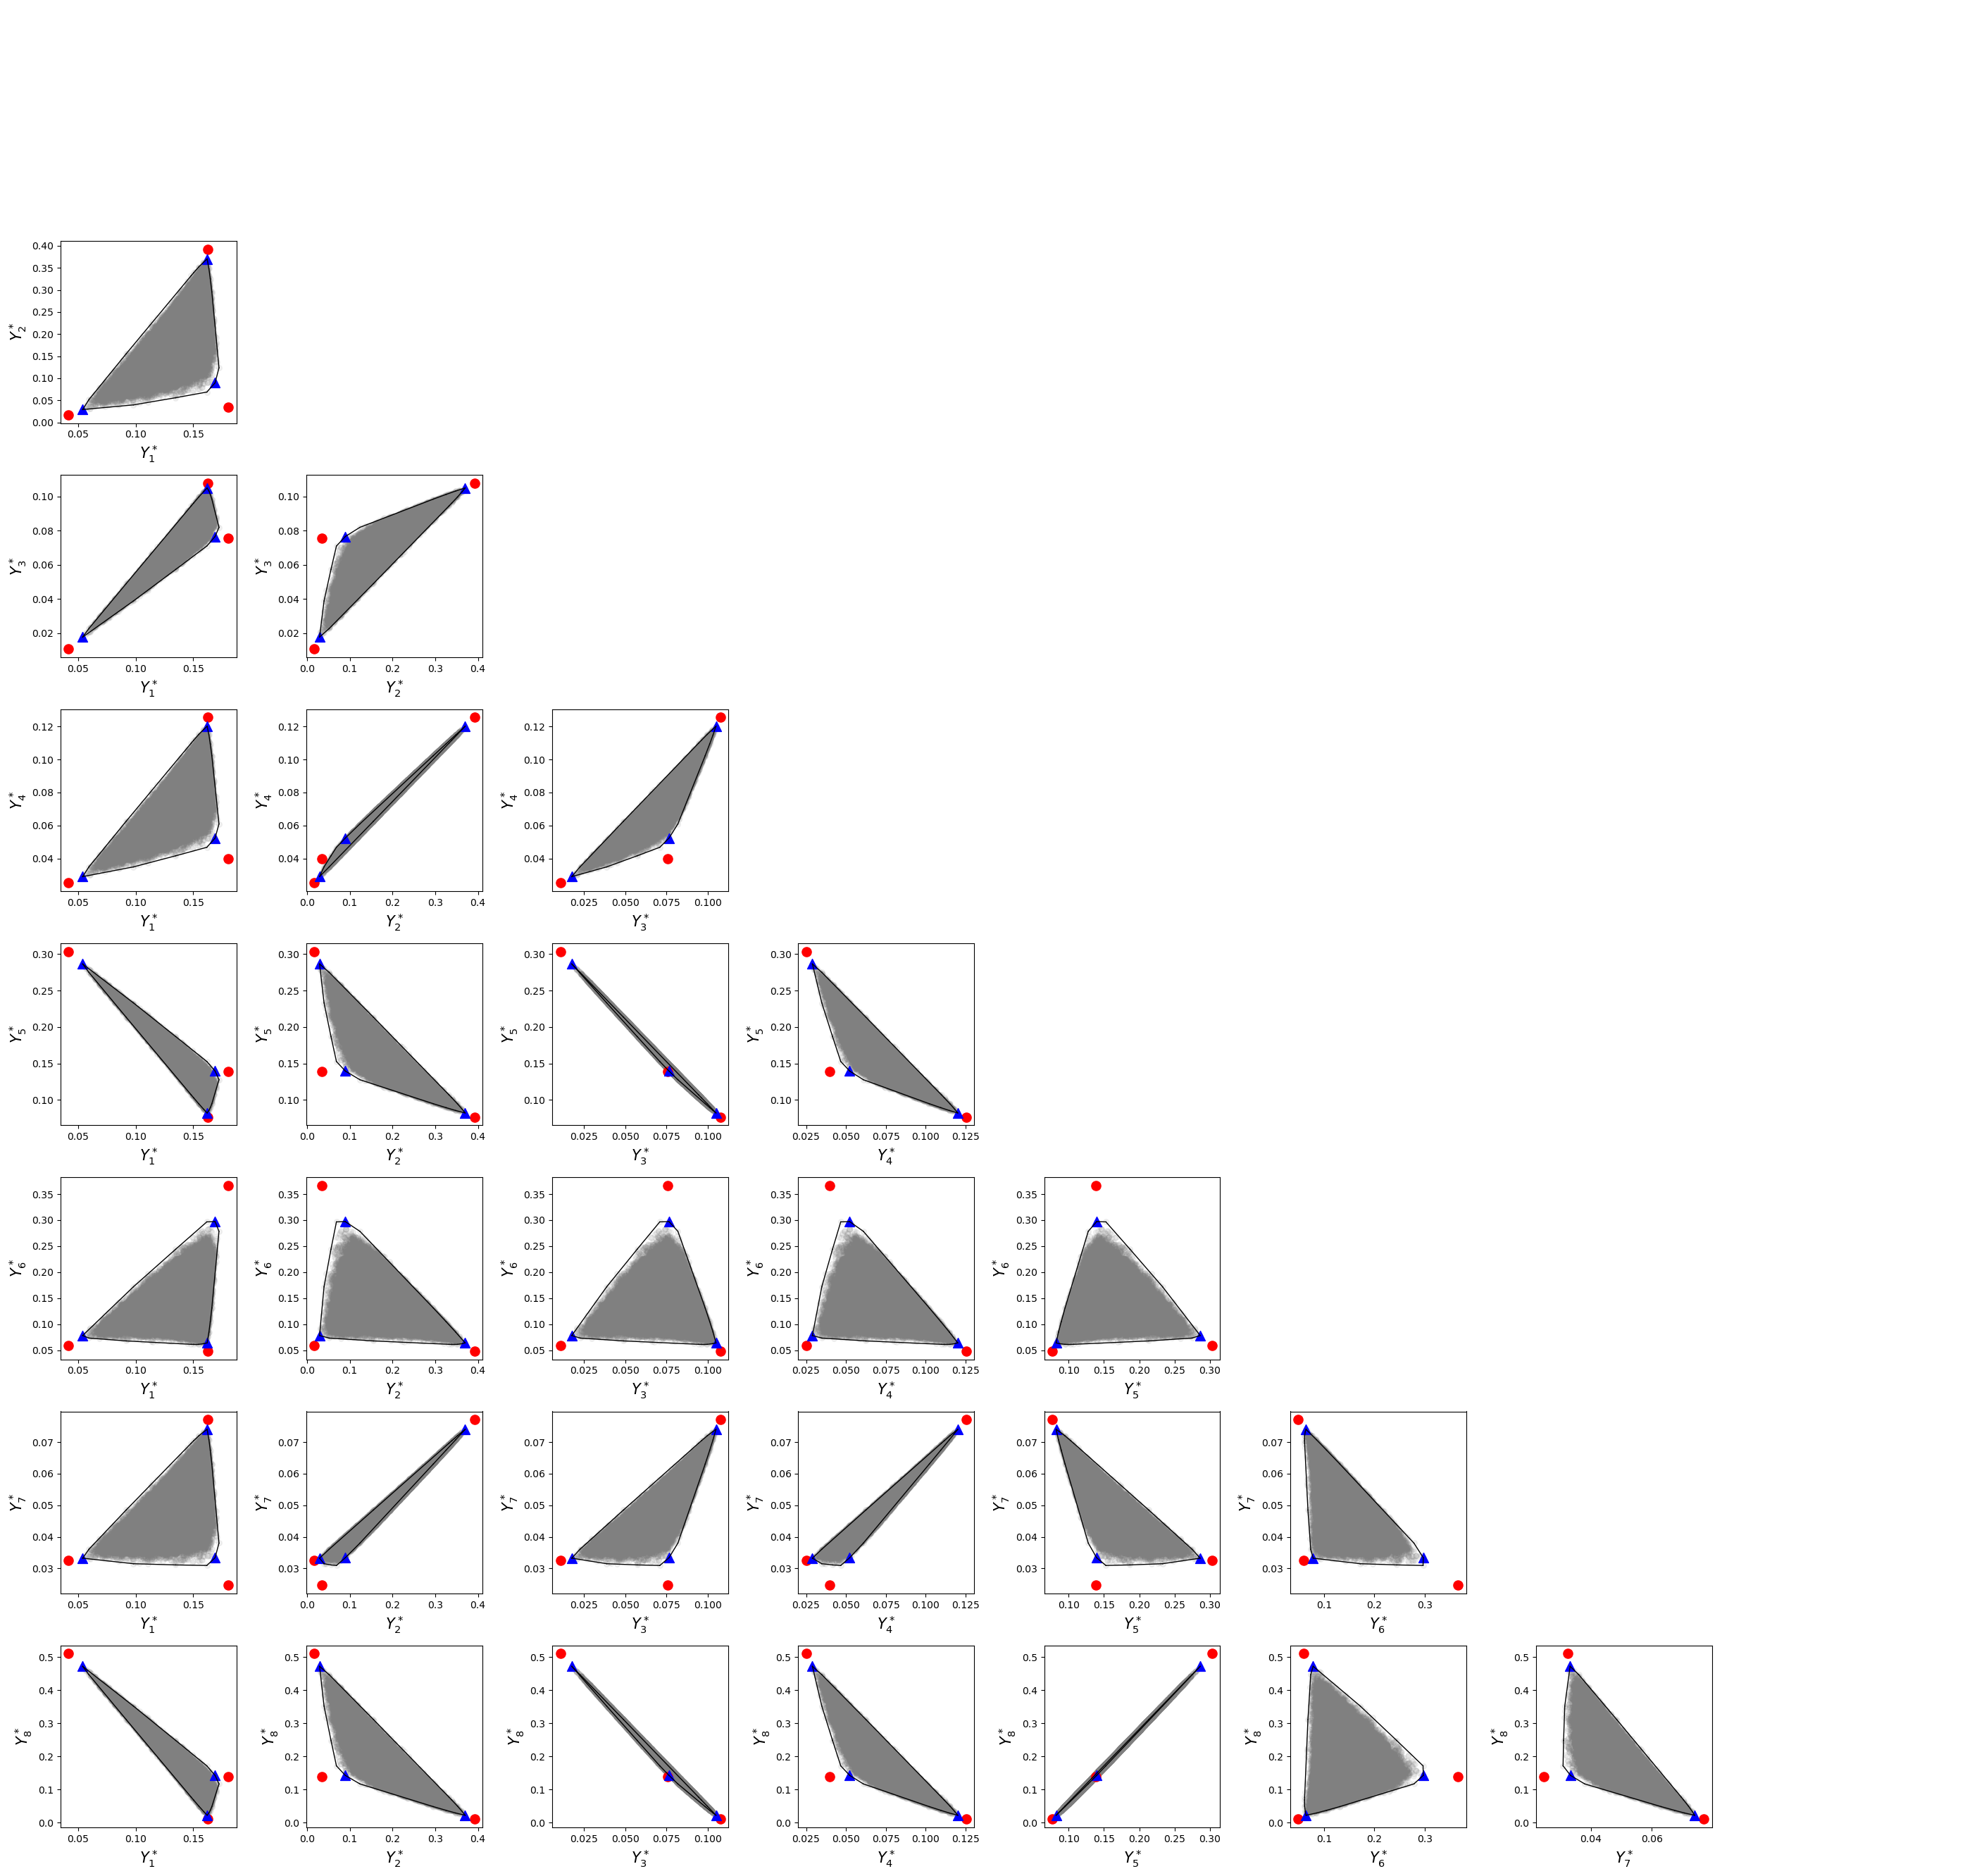

In [18]:
n = 100000
seed = n
H_star_hat = results[n]["estimates"]["H_star_hat_nfindr"][0,:,:]
Y, Y_star, r, H, H_star, W, mu, W_tilde, mu_tilde, W_star, C, C_alt = simulate_dataset(n=n, K=K, J=J, seed=seed, process="ar1")
plot_full_scatter_matrix(Y_star, 
                         H=H_star, 
                         H_hat=H_star_hat, 
                         alpha=0.1, 
                         labels=[rf"$Y^*_{{{j+1}}}$" for j in range(J)],
                         draw_diagonal=False,
                         title=None, 
                         quantile=None, 
                         # savepath=outdir/f"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_HwScatter_n{n}.png"
)

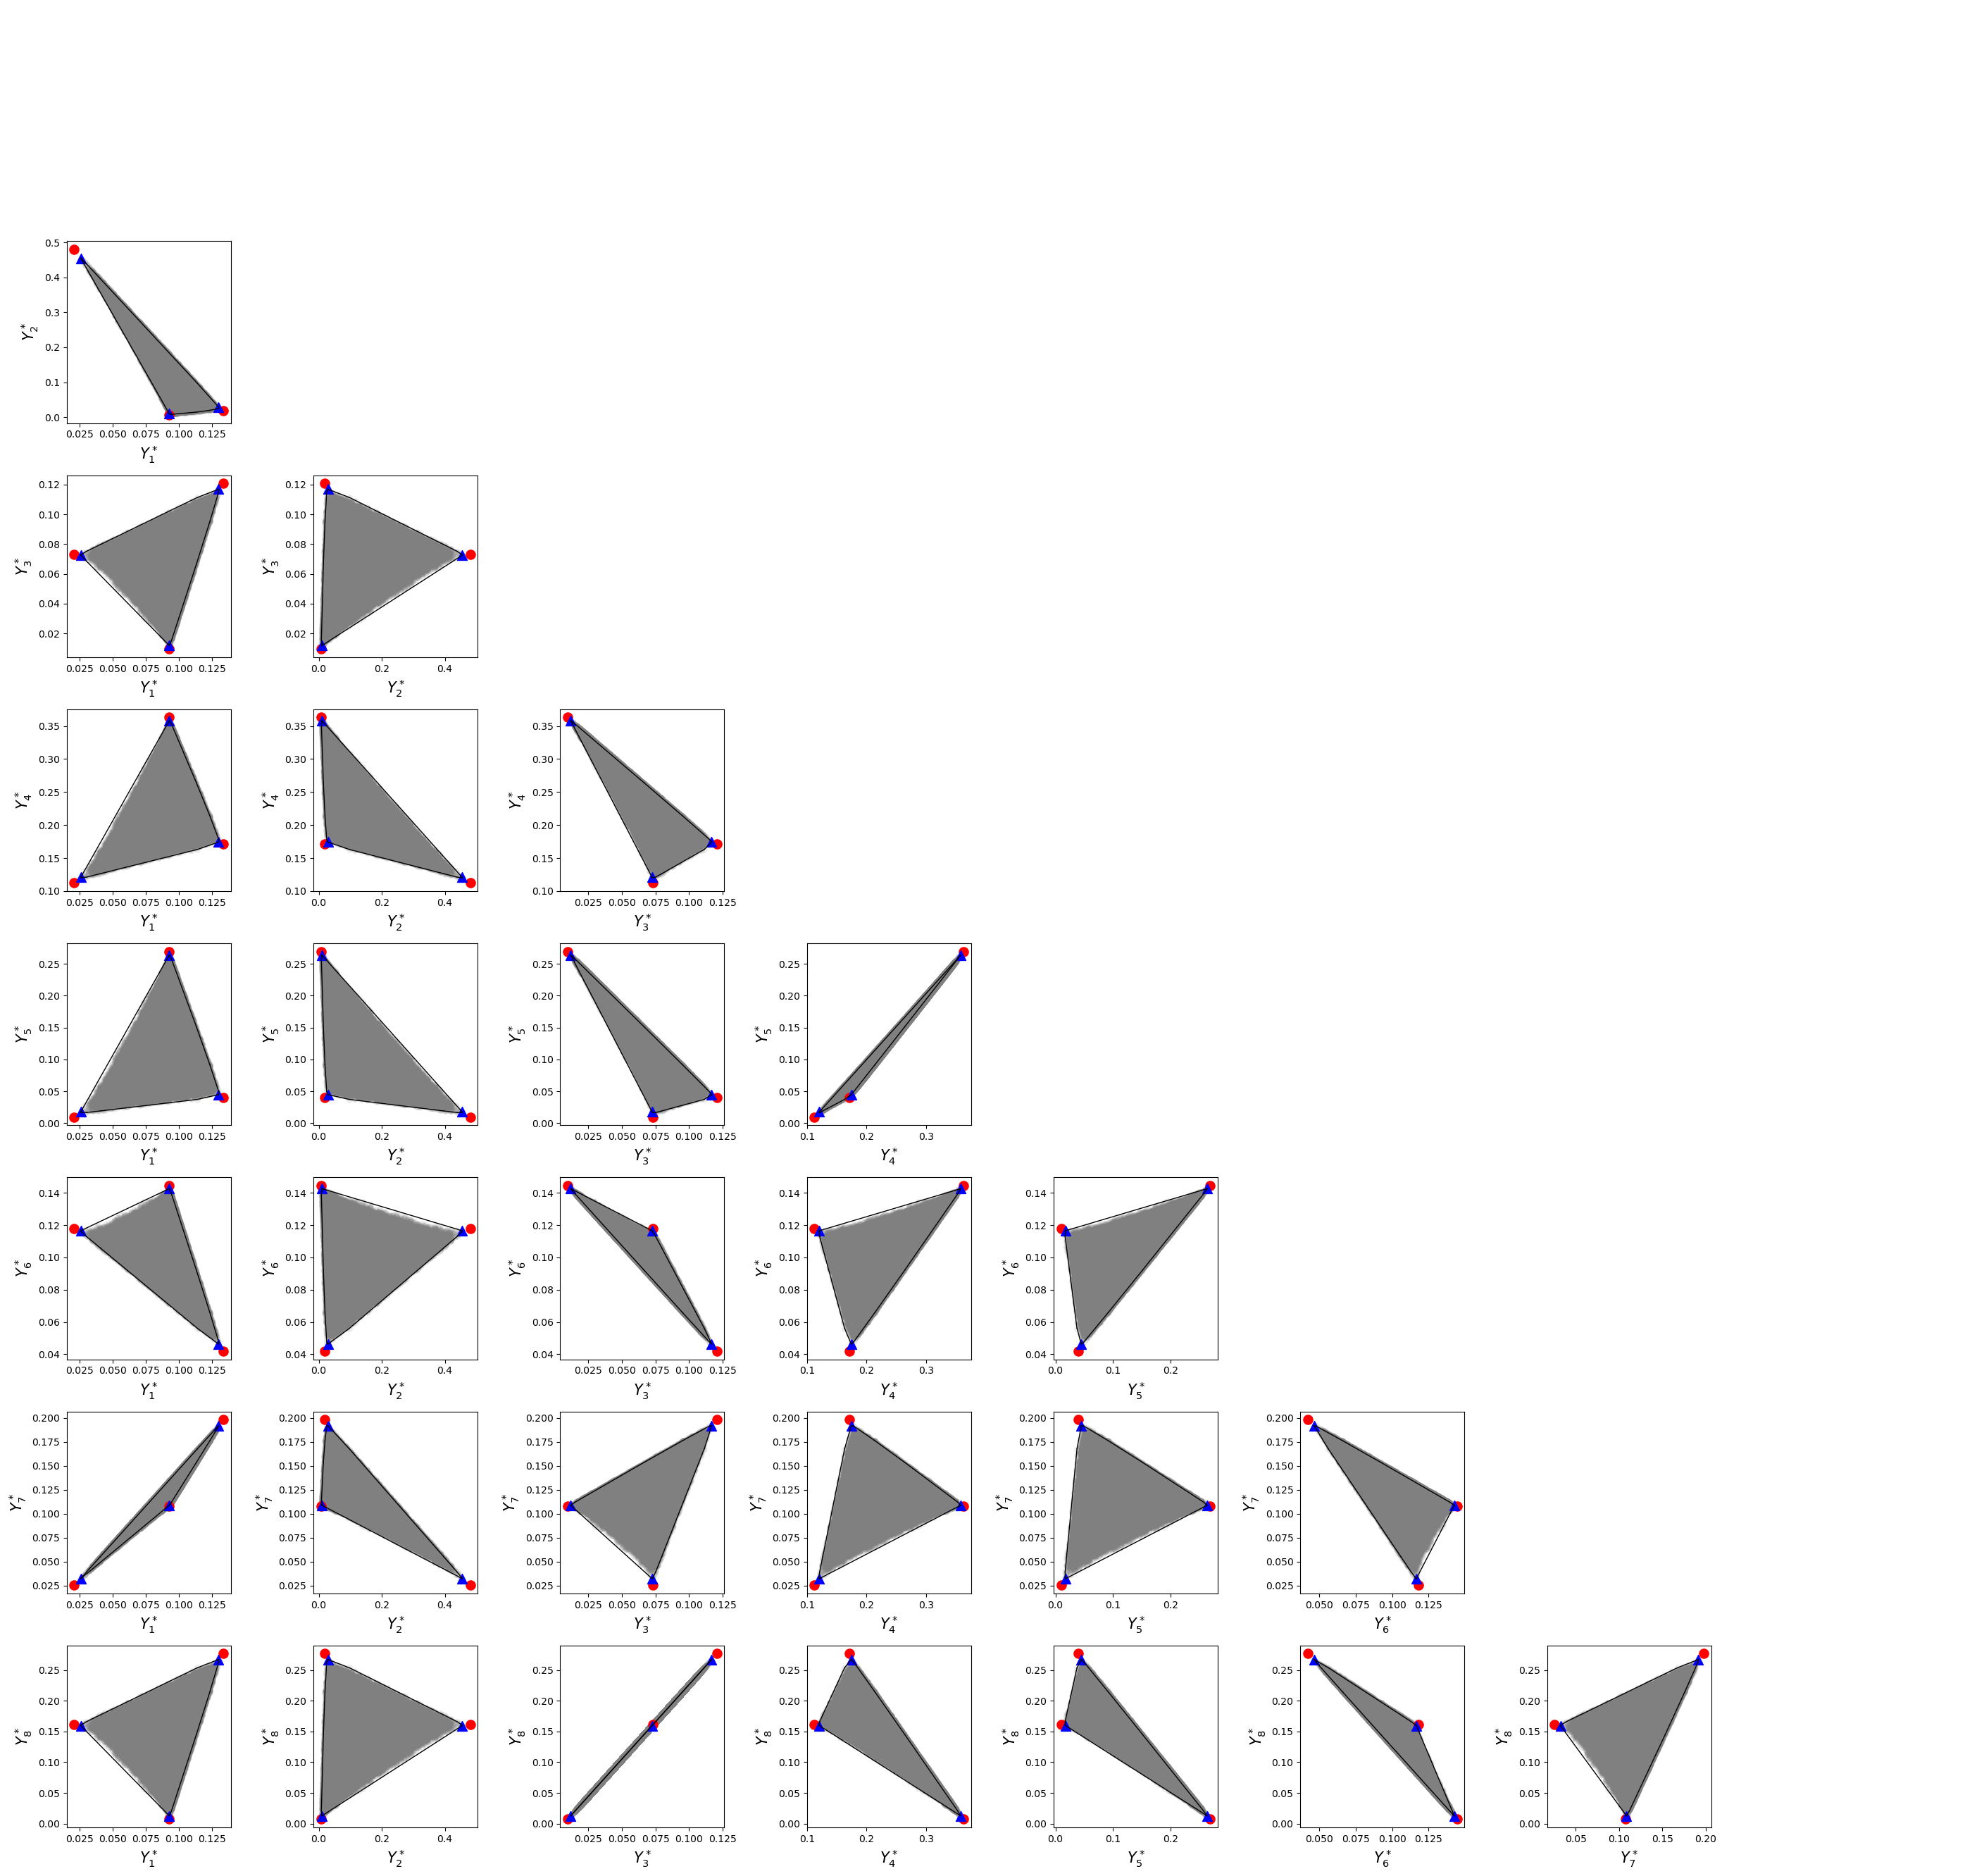

In [20]:
n = 500000
seed = n
H_star_hat = results[n]["estimates"]["H_star_hat_nfindr"][0,:,:]
Y, Y_star, r, H, H_star, W, mu, W_tilde, mu_tilde, W_star, C, C_alt = simulate_dataset(n=n, K=K, J=J, seed=seed, process="ar1")
plot_full_scatter_matrix(Y_star, 
                         H=H_star, 
                         H_hat=H_star_hat, 
                         alpha=0.1, 
                         labels=[rf"$Y^*_{{{j+1}}}$" for j in range(J)],
                         draw_diagonal=False,
                         title=None, 
                         quantile=None, 
                         # savepath=outdir/f"figure/sourceXray_convergence_sims_ar1W_RinvH_J8K3_HwScatter_n{n}.png"
)